# Taller de procesamiento de lenguaje natural (NLP) y neurociencias. Semana de la física, Facultad de Ciencias Exactas y Naturales, junio 2025.

# Bibliotecas y funciones

La primera celda pide un par de autorizaciones

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import seaborn as sns
import pandas as pd
from scipy.spatial import distance
import time
import numpy as np
import re

Mounted at /content/drive


Esto es lo más lento de todo. Ejecutar con tiempo, pero evitar que se pierda la conexión. Para esto último, se puede usar el time.sleep(...) que está más abajo.

In [ ]:
!pip install fasttext
import fasttext
ft = fasttext.load_model('/content/drive/MyDrive/TallerNLP/cc.es.300.bin')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313506 sha256=2c2de44e8b1839d29d22b57e34dfc4ab92e98fc412167ebeb80be5f4ff945eb5
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
symbols = ['\n',
    '¿','?','~','`','!','¡','@','#','$','%','^',
    '*','(',')','_','-','+','=','{','}','[',
    ']','\\',':',';','<','>','/', '.', ',','&',
    '\r','\t', '|', '“', '"', '–', '”', '©', '-', '—',
    '…', ';', '‘','’', '1', '2', '3', '4', '5', '6', '7',
     '8', '9', '0', "'", '«', '»'
]

with open('/content/drive/MyDrive/TallerNLP/spanish_sw.txt', "r") as file: # abrimos el .txt
        lineas = file.readlines()
        sw = [l[:-1] for l in lineas]
        sw.extend(['física', 'físicas'])

def remove_symbols (text) -> str:
    res = text
    for char in symbols:
        res = res.replace(char, ' ')
    return res.split(' ')

def limpiar(rows) -> list:
    text = str(rows)
    res = []
    subwords = remove_symbols(text)
    for item in subwords:
        item = item.lower()
        if not item in sw and item.isalpha and item!='' and len(item)>1:
            res.append(item)
    return res

def nube(validas):
    text = ' '.join(validas)
    wordcloud = WordCloud(collocations=False, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Para mantener conectado el colab

In [ ]:
time.sleep(20000)

KeyboardInterrupt: 

# Un poco de contexto sobre el procesamiento de lenguaje natural y un ejemplo

- Basado en el trabajo de Matías Battocchia

Este es el artículo final de la serie preprocesamiento de texto para NLP. Los artículos anteriores son [parte 1](Preprocesamiento-de-texto-para-NLP-parte-1.html) y [parte 2](Preprocesamiento-de-texto-para-NLP-parte-2.html).

En este nos vamos a focalizar en *embeddings* pre-entrenados. Los *embeddings* son un tema central en procesamiento del lenguaje y mucho se ha escrito al respecto. Acá hay algunos enlaces para introducrise en el tema
* [The illustrated Word2Vec](http://jalammar.github.io/illustrated-word2vec)
* [CS224n presentación *word vectors*](http://web.stanford.edu/class/cs224n/slides/cs224n-2020-lecture01-wordvecs1.pdf)
* [CS224n trabajo práctico *word vectors*](http://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html)

Los embeddings son la primera capa en las redes neuronales que procesan texto. Mapean índices (a cada tóken le corresponde un índice, los índices corren de cero hasta `len(tókenes)`). Estamos mapeando enteros a vectores, a cada índice le corresponde un vector de palabra que codifica a la palabra. El mapeo se realiza por medio de una matriz que tiene tantas filas como índices y tantas columnas como la dimensión de los vectores. Esta dimensión es un hiperparámetro del modelo y básicamente significa la cantidad de atributos con la que representaremos a las palabras. Elegir una fila de la matriz, y a cada índice/tóken le corresponde una fila) estamos rebanando la matriz de modo de quedarnos con un vector.

Como el resto de las capas de una red neuronal que no ha sido entrenada los pesos de la capa de *embeddings* se inicializan al azar. O sea que al seleccionar un vector de palabra obtenemos un vector con componentes aleatorios. La idea central de los *embeddings* es que las palabras adquieren significado a partir de las palabras que la rodean. Una vez que la red neural ha sido entrenada y que los componentes de los vectores de palabras no son azarosos sino que han capturado en mayor o menor medida el significado de las palabras, la distancia entre los vectores ([similitud del coseno](https://es.wikipedia.org/wiki/Similitud_coseno) es una forma de calcular la distancia entre vectores) de palabras similares es más corta, es decir los *embeddings* están más cerca, que si cuando se consideran palabras con significados disímiles.

Una de las primeras técnicas de transfencia de aprendizaje (*transfer learning*) fue utilizar *embeddings* pre-entrenados. La red neuronal con la que son entrenados y la que los utiliza con otros fines pueden tener arquitecturas bien distintas, comparten solamente los vectores de palabras, es decir la primera capa. Vimos que el armado del vocabulario es un asunto central y sería extraño que adoptemos el mismo vocabulario que la red que se utilizó para entrenar los *embeddings*; no es esto un problema mientras haya una intersección substancial entre el vocabulario que queremos utilizar y el que se utilizó para los *embeddings*, ya que nos estamos limitando a este último, posiblemente entrenado con un corpus general (Wikipedia) mientras que el vocabulario que necesitamos posiblemente pertenezca a un corpus particular. Todos los tókenes que no están en el vocabulario se denominan **fuera del vocabulario** (*out-of-vocabulary* u OOV) y requieren un tratamiento especial como ser ignorados/eliminados o mapeados a un tóken especial que codifique tókenes desconocidos.

Los índices del vocabulario que crearemos tampoco será el mismo que los que se usaron para los vectores pre-entrenados. Por lo tanto la estrategia para obtener los pesos de la capa de vectores de palabra es la siguiente.

1. Descargar los vectores pre-entrenados
2. Obtener los vectores del vocabulario propio
3. Ordenar los vectores según los índices propios
4. Crear un tensor
5. Inicializar los pesos de la capa de *embeddings*

La interfaz de fastText para obtener un vector a partir de un tóken es como la de un diccionario. Así luce un *embedding* de dimensión 300. Probamos en vivo con la palabra Messi y palabras asociadas

In [ ]:
ft['Messi']

array([-0.01793711, -0.04318793,  0.08850024,  0.12935686,  0.01847667,
       -0.08063798, -0.01535255, -0.03529128, -0.01352771, -0.10946947,
        0.05725989, -0.03805202, -0.17602465, -0.00685614, -0.15586333,
       -0.13896571, -0.03206563, -0.05236012,  0.24397115, -0.00842743,
       -0.03935202,  0.05744439,  0.04429762, -0.0263277 , -0.01776601,
       -0.20154452, -0.07011402, -0.12310888,  0.02259159, -0.01280158,
       -0.02600347, -0.08293456,  0.18392691, -0.00767446,  0.0437278 ,
       -0.11070497, -0.08144037, -0.00157289, -0.04543768,  0.07912381,
        0.07070263, -0.0148467 , -0.09346919,  0.04288066, -0.1588057 ,
       -0.01761109, -0.00517852,  0.03357588,  0.05717016, -0.0349888 ,
       -0.04935153,  0.01446165, -0.07613968,  0.10919786, -0.06388927,
        0.10318582, -0.02906681, -0.05575696, -0.06540089, -0.02921641,
        0.02300162,  0.07125753, -0.02830457, -0.02850453, -0.04552109,
       -0.07080565, -0.01625527,  0.095651  ,  0.00794625, -0.03

Para calcular la distancia entre vectores utilizaré la similitud del coseno, una fórmula trigonométrica que en la definición de `scipy` es igual a cero si ambos vectores apuntan a un mismo lugar; cualquier ángulo existente entre los vectores, arrojaría un valor mayor a cero.

In [ ]:
distance.cosine(ft['Messi'], ft['Lechuga'])

np.float32(0.84848094)

# Análisis en vivo de los datos. Ejecutar al terminar el juego.

Función auxiliar que voy a usar para limpiar las listas de palabras vacías, guardar el número de equipo y guardar la palabra secreta

In [ ]:
def casa_arbol (rows):
    listas_limpias = []
    secretas = []
    equipos = []
    for r in rows:
        palabras = [p.lower() for p in r[2:-2] if p!=''] #guardo solo las palabras, en minúsculas
        limpia = [p.strip() for p in palabras]
        if len(limpia)>0:
            listas_limpias.append(limpia)
            secretas.append(r[-1].lower().strip())
            equipos.append(r[1])
    return listas_limpias, secretas, equipos

Cargo los datos del formulario. La fila 0 es el encabezado de cada columna, así que solo muestro de la 1 hacia abajo. Limpio las listas para evitar formularios vacíos.

In [ ]:
worksheet = gc.open('Respuestas_casaarbol').sheet1

# get_all_values gives a list of rows.
rows_casa = worksheet.get_all_values()[1:]
validas, secretas, equipos = casa_arbol(rows_casa[:])  #139: respuestas a partir del martes 24/6/25

Muestro las palabras que salieron y las secretas, sin las stop words

In [ ]:
for i in range(len(validas)):
    print('Palabras:', validas[i],  "Secreta:", secretas[i])

Palabras: ['árbol', 'persona', 'persona', 'persona', 'persona', 'persona', 'prócer', 'prócer', 'san martín', 'héroe', 'héroe', 'héroe', 'héroe', 'héroe', 'héroe', 'héroe', 'héroe', 'héroe', 'héroe', 'héroe'] Secreta: misión
Palabras: ['casa', 'casa', 'objeto', 'objeto', 'objeto', 'utensilios', 'utensilios', 'utensilios', 'utensilios', 'cuchillo'] Secreta: cuchillo
Palabras: ['casa', 'casa', 'muebles', 'muebles', 'objeto', 'objeto', 'objeto', 'mesa', 'mesa', 'mesa', 'mantel', 'mantel', 'mano'] Secreta: mano
Palabras: ['árbol', 'arbol', 'animal', 'animal', 'animal', 'tierra', 'tierra', 'tierra', 'tierra', 'tierra', 'hormiga', 'hormiga', 'hormiga', 'hormiga', 'hormiga', 'hormiga', 'hormiga', 'rama', 'rama', 'rama'] Secreta: desierto
Palabras: ['árbol', 'arbol', 'árbol', 'árbol', 'árbol', 'árbol', 'árbol', 'árbol', 'árbol', 'lluvia'] Secreta: lluvia
Palabras: ['árbol', 'animal', 'animal', 'chico'] Secreta: chico
Palabras: ['casa', 'baño', 'cuarto', 'cocina', 'comida', 'luz', 'elecrodomesti

Nube de palabras

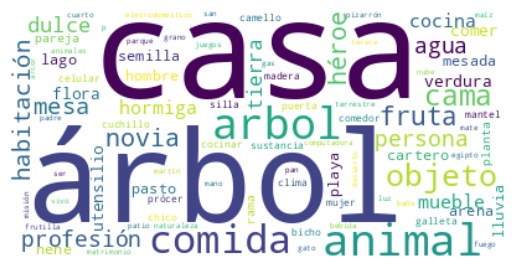

In [ ]:
nube([palabra for lista in validas for palabra in lista])

Gráfico de distancia semántica en función del avance

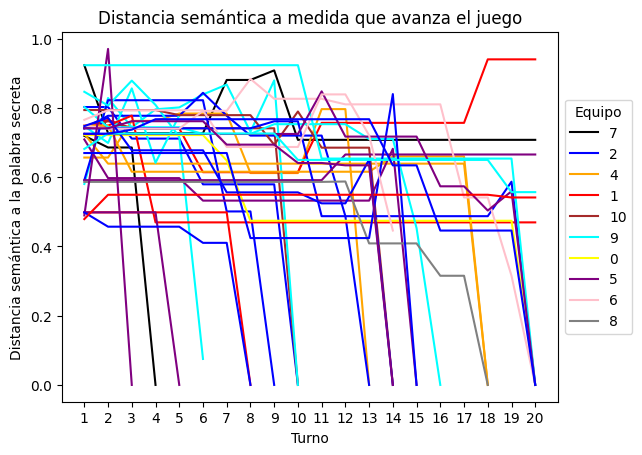

In [ ]:
colores = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'black',
           'grey', 'cyan', 'brown', 'yellow']
set_equipo = set(equipos)
for i in range(len(validas)):
    objetivo = secretas[i]
    equipo = equipos[i]
    color = colores[int(equipo)-1]
    turnos = range(1,len(validas[i])+1)
    y = [distance.cosine(ft[objetivo], ft[v]) for v in validas[i]]
    if equipo in set_equipo:
        plt.plot(turnos,y, label=str(equipo), color=color)
        set_equipo.remove(equipo)
    else:
        plt.plot(turnos,y, color=color)

plt.title('Distancia semántica a medida que avanza el juego')
plt.xlabel('Turno')
plt.ylabel('Distancia semántica a la palabra secreta')
plt.xticks(range(1,21))
plt.legend(title='Equipo', loc='center left', bbox_to_anchor=(1, 0.5))

## Preguntas disparadoras/que podrían explorarse en vivo/propuestas

¿Qué palabras están cerca del centroide? ¿cuáles están en la periferia? ¿sería una mejor estrategia que la palabra objetivo esté en la periferia o una cerca del centroide? ¿Se podrá usar la distancia semántica para decir cuál es el color más triste? ¿y el más alegre? ¿Habrá correlación entre la distancia geográfica y la distancia semántica entre países?

Se puede usar NLTK para clasificar las palabras en concretas o abstractas. Luego, separar los gráficos de las partidas con palabras concretas y con palabras abstractas.

# Cuentos

Vamos a usar El cautivo, de Jorge Luis Borges y Vida al natural, de Clarice Lispector.

In [ ]:
explicitas1 = ['chico', 'padre', 'desierto', 'puerta', 'cocina', 'cuchillo']

explicitas2 = ['fuego', 'lluvia', 'leño', 'mujer', 'mano', 'misión']

comunes = ['hombre']

Calculamos la cantidad de turnos según si la palabra secreta está escrita en el cuento que leyeron, está en el otro cuento o no está en ninguno. Se da lo esperado: que si la palabra secreta apareció en el cuento leído, se tarda menos en adivinarla.

In [ ]:
#equipos, secretas, validas
turnos_coincidencia, turnos_no_coincidencia = [], []
for i in range(len(validas)):

    if int(equipos[i]) % 2 == 0:  #si el equipo es par (si tiene Vida al natural)
        if secretas[i].lower() in explicitas2:  #si la palabra secreta es de Vida al natural
            turnos_coincidencia.append(len(validas[i]))
        else: #si no aparece en ninguno de los dos cuentos
            turnos_no_coincidencia.append(len(validas[i]))

    else: #si el equipo es impar (si tiene El cautivo)
        if secretas[i].lower() in explicitas1:  #si la palabra secreta es de Vida al natural
            turnos_coincidencia.append(len(validas[i]))
        else: #si no aparece en ninguno de los dos cuentos
            turnos_no_coincidencia.append(len(validas[i]))

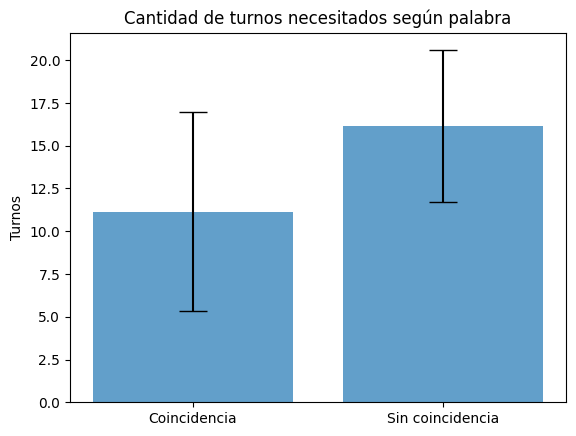

In [ ]:
labels = ['Coincidencia', 'Sin coincidencia']  # Labels for the bars
means = [np.mean(turnos_coincidencia), np.mean(turnos_no_coincidencia)]  # Mean values for each bar
std_devs = [np.std(turnos_coincidencia), np.std(turnos_no_coincidencia)]  # Standard deviations for each bar

x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots()
bars = ax.bar(x, means, yerr=std_devs, tick_label=labels, align='center', alpha=0.7, ecolor='black', capsize=10)

ax.set_ylabel('Turnos')
ax.set_title('Cantidad de turnos necesitados según palabra')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()